# Exploring Word Embeddings with New Deep Learning Models

Traditional (count-based) feature engineering strategies for textual data involve models belonging to a family of models popularly known as the Bag of Words model. This includes term frequencies, TF-IDF (term frequency-inverse document frequency), N-grams and so on. While they are effective methods for extracting features from text, due to the inherent nature of the model being just a bag of unstructured words, we lose additional information like the semantics, structure, sequence and context around nearby words in each text document.

This forms as enough motivation for us to explore more sophisticated models which can capture this information and give us features which are vector representation of words, popularly known as embeddings.

Predictive methods like Neural Network based language models try to predict words from its neighboring words looking at word sequences in the corpus and in the process it learns distributed representations giving us dense word embeddings. We will be focusing on these predictive methods in this article.

# Prepare a Sample Corpus

In [2]:
import pandas as pd
import numpy as np

pd.options.display.max_colwidth = 200

corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick and the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beautiful today,weather
7,The dog is lazy but the brown fox is quick!,animals


# Simple Text Pre-processing

Since the focus of this unit is on feature engineering, we will build a simple text pre-processor which focuses on removing special characters, extra whitespaces, digits, stopwords and lower casing the text corpus.

In [3]:
import nltk
import re

stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(corpus)
norm_corpus

array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog',
       'kings breakfast sausages ham bacon eggs toast beans',
       'love green eggs ham sausages bacon',
       'brown fox quick blue dog lazy', 'sky blue sky beautiful today',
       'dog lazy brown fox quick'], dtype='<U51')

# The Word2Vec Model

This model was created by Google in 2013 and is a predictive deep learning based model to compute and generate high quality, distributed and continuous dense vector representations of words, which capture contextual and semantic similarity. Essentially these are unsupervised models which can take in massive textual corpora, create a vocabulary of possible words and generate dense word embeddings for each word in the vector space representing that vocabulary.

Usually you can specify the size of the word embedding vectors and the total number of vectors are essentially the size of the vocabulary. This makes the dimensionality of this dense vector space much lower than the high-dimensional sparse vector space built using traditional Bag of Words models.

There are two different model architectures which can be leveraged by Word2Vec to create these word embedding representations. These include,

    The Continuous Bag of Words (CBOW) Model
    The Skip-gram Model


# The Continuous Bag of Words (CBOW) Model

The CBOW model architecture tries to predict the current target word (the center word) based on the source context words (surrounding words).

Considering a simple sentence, “the quick brown fox jumps over the lazy dog”, this can be pairs of (context_window, target_word) where if we consider a context window of size 2, we have examples like ([quick, fox], brown), ([the, brown], quick), ([the, dog], lazy) and so on.

Thus the model tries to predict the target_word based on the context_window words.

# The Skip-gram Model

The Skip-gram model architecture usually tries to achieve the reverse of what the CBOW model does. It tries to predict the source context words (surrounding words) given a target word (the center word).

Considering our simple sentence from earlier, “the quick brown fox jumps over the lazy dog”. If we used the CBOW model, we get pairs of (context_window, target_word) where if we consider a context window of size 2, we have examples like ([quick, fox], brown), ([the, brown], quick), ([the, dog], lazy) and so on.

Now considering that the skip-gram model’s aim is to predict the context from the target word, the model typically inverts the contexts and targets, and tries to predict each context word from its target word. Hence the task becomes to predict the context [quick, fox] given target word ‘brown’ or [the, brown] given target word ‘quick’ and so on.

Thus the model tries to predict the context_window words based on the target_word.

# Robust Word2Vec Model with Gensim

The gensim framework, created by Radim Řehůřek consists of a robust, efficient and scalable implementation of the Word2Vec model. We will leverage the same on our sample toy corpus. In our workflow, we will tokenize our normalized corpus and then focus on the following four parameters in the Word2Vec model to build it.

    size: The word embedding dimensionality
    window: The context window size
    min_count: The minimum word count
    sample: The downsample setting for frequent words
    sg: Training model, 1 for skip-gram otherwise CBOW

We will build a simple Word2Vec model on the corpus and visualize the embeddings.

In [8]:
import nltk
from gensim.models import word2vec

tokenized_corpus = [nltk.word_tokenize(doc) for doc in norm_corpus]

# Set values for various parameters
feature_size = 15    # Word vector dimensionality  
window_context = 20  # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3        # Downsample setting for frequent words
sg = 1               # skip-gram model

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sg=sg, sample=sample, iter=5000)
w2v_model

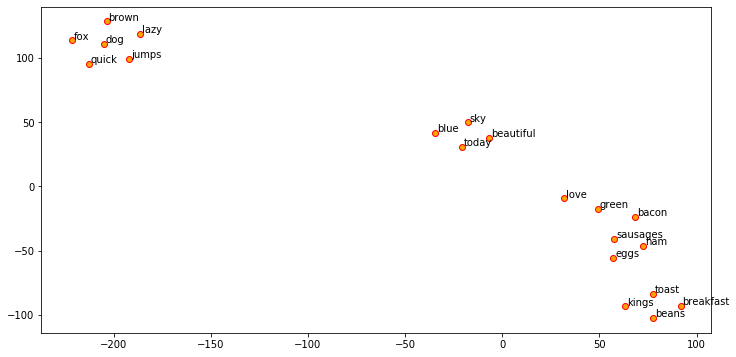

In [9]:
import matplotlib.pyplot as plt

%matplotlib inline

# visualize embeddings
from sklearn.manifold import TSNE

words = w2v_model.wv.index2word
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=42, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [10]:
w2v_model.wv['sky'], w2v_model.wv['sky'].shape

(array([-0.64029545, -1.2060286 , -0.04209023,  0.54754347, -0.27795702,
         0.35819978, -0.06071265, -1.5856253 , -0.49058118,  0.46679756,
        -0.5478085 , -0.5554019 ,  0.22428001,  0.04621512,  1.0449426 ],
       dtype=float32), (15,))

In [11]:
vec_df = pd.DataFrame(wvs, index=words)
vec_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
sky,-0.640295,-1.206029,-0.042090,0.547543,-0.277957,0.358200,-0.060713,-1.585625,-0.490581,0.466798,-0.547809,-0.555402,0.224280,0.046215,1.044943
blue,-0.554355,-0.612556,-0.364005,0.316496,0.003008,0.007918,-0.037077,-1.084624,-0.256964,0.119207,-0.604978,-0.161987,0.285252,0.223060,0.926865
beautiful,-0.366766,-1.050452,-0.055396,0.365410,-0.236081,0.220189,-0.348783,-1.589690,-0.405130,0.365967,-0.412458,-0.525461,0.078260,0.347585,0.980780
quick,-0.142678,0.018232,-0.901412,0.822163,0.280056,0.114032,0.740235,-0.651472,-0.146581,-0.723259,-0.925296,0.383209,-0.195101,0.995260,1.187650
brown,-0.265498,-0.181799,-0.885923,0.743649,0.346070,0.157006,1.182942,-0.648491,-0.157644,-0.674362,-0.810831,0.442465,0.103325,0.891319,1.138084
fox,-0.319425,0.054786,-0.875118,0.816765,0.242912,0.131701,1.010497,-0.741869,-0.063646,-0.703140,-0.830138,0.455054,-0.338789,0.828924,1.212464
lazy,-0.054475,-0.192840,-0.991689,0.756110,0.182923,0.319950,1.109705,-0.711092,-0.331445,-0.586171,-0.995148,0.658631,0.071540,0.841324,0.972923
dog,-0.219278,-0.004337,-0.722354,0.694752,0.404641,0.278714,0.938632,-0.660047,-0.114009,-0.648634,-0.885394,0.522598,-0.272578,0.841120,1.286652
love,0.251476,-0.569728,-0.306866,0.442464,-0.137760,0.362442,-0.174202,-0.633821,-0.159524,0.783198,0.323485,-0.690643,-0.135715,0.010243,0.473220
sausages,0.952480,-0.517545,-0.485226,0.690537,0.145918,0.179542,0.552453,-0.110417,0.162380,0.937115,0.307641,-1.128945,-0.580019,0.166744,0.596872
